In [142]:
# 모듈로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.classification import F1Score
from torchinfo import summary


from torch.utils.data import Dataset,DataLoader

import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder      # 타겟컬럼 수치화

In [143]:
torch.manual_seed(1)

In [144]:
irisDF=pd.read_csv('C:\KDT\수업\MachineLearning\data\iris.csv')
targetDF=irisDF[irisDF.columns[[-1]]]
featureDF=irisDF[irisDF.columns[:-1]]
print(featureDF.shape,targetDF.shape)

(150, 4) (150, 1)


In [145]:
# target 인코딩
encoder=OneHotEncoder()
targetDF=encoder.fit_transform(targetDF)
targetAr=targetDF.toarray()
targetAr.shape

(150, 3)

In [146]:
featureTS=torch.FloatTensor(featureDF.values)
targetTS=torch.FloatTensor(targetAr)

In [147]:
class CustomModel(nn.Module):
    
    def __init__(self,in_in,out_out,num_list=[]):
        super().__init__()
        self.num_list=num_list
        self.in_layer=nn.Linear(in_in,num_list[0] if len(num_list) else 5)
        self.h_layer=nn.ModuleList()
        for idx in range(len(num_list)-1):
            self.h_layer.append(nn.Linear(num_list[idx],num_list[idx+1]))
        self.out_layer=nn.Linear(num_list[-1] if len(num_list) else 5,out_out)

    def forward(self,X):
        X=F.relu(self.in_layer(X))
        for model in self.h_layer:
            X=model(X)
            X=F.relu(X)
        X=self.out_layer(X)
        return F.sigmoid(X)


In [148]:
model=CustomModel(featureTS.shape[1],targetTS.shape[1],num_list=[10,20,30,10])

In [149]:
model.parameters

<bound method Module.parameters of CustomModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (h_layer): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
  (out_layer): Linear(in_features=10, out_features=3, bias=True)
)>

In [150]:
summary(model)

Layer (type:depth-idx)                   Param #
CustomModel                              --
├─Linear: 1-1                            50
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       220
│    └─Linear: 2-2                       630
│    └─Linear: 2-3                       310
├─Linear: 1-3                            33
Total params: 1,243
Trainable params: 1,243
Non-trainable params: 0

In [151]:
optimizer=optim.Adam(model.parameters(),lr=0.0005)

In [152]:
def training(featureTS,targetTS,EPOCH,BATCH_SIZE=10):
    BATCH_CNT=featureTS.shape[0]//BATCH_SIZE
    loss_list=[]
    for epoch in range(EPOCH):
        total_loss=0
        for i in range(BATCH_CNT):
            start=i * BATCH_SIZE
            end=start + BATCH_SIZE

            BS_feature=featureTS[start:end]
            BS_target=targetTS[start:end]

            pre_y=model(BS_feature)
            loss=nn.CrossEntropyLoss()(pre_y,BS_target)
            total_loss+=loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'[{epoch+1}/{EPOCH}] AVG LOSS {total_loss/BATCH_CNT}')
        loss_list.append(total_loss/BATCH_CNT)

    return loss_list

In [153]:
EPOCH=5000
loss_list=training(featureTS,targetTS,EPOCH,BATCH_SIZE=50)

[1/5000] AVG LOSS 1.1000403960545857
[2/5000] AVG LOSS 1.0993346373240154
[3/5000] AVG LOSS 1.0990129709243774
[4/5000] AVG LOSS 1.0987436374028523
[5/5000] AVG LOSS 1.09849218527476
[6/5000] AVG LOSS 1.0982545614242554
[7/5000] AVG LOSS 1.0980308055877686
[8/5000] AVG LOSS 1.0978197654088337
[9/5000] AVG LOSS 1.097615639368693
[10/5000] AVG LOSS 1.0974070231119792
[11/5000] AVG LOSS 1.0971885919570923
[12/5000] AVG LOSS 1.0969651540120442
[13/5000] AVG LOSS 1.09674068291982
[14/5000] AVG LOSS 1.0965114831924438
[15/5000] AVG LOSS 1.0962649583816528
[16/5000] AVG LOSS 1.0959631601969402
[17/5000] AVG LOSS 1.095605452855428
[18/5000] AVG LOSS 1.0952938397725422
[19/5000] AVG LOSS 1.0950077772140503
[20/5000] AVG LOSS 1.0947293440500896
[21/5000] AVG LOSS 1.0944455464680989
[22/5000] AVG LOSS 1.0941496292750041
[23/5000] AVG LOSS 1.093841791152954
[24/5000] AVG LOSS 1.0935228268305461
[25/5000] AVG LOSS 1.0931868155797322
[26/5000] AVG LOSS 1.0928359826405842
[27/5000] AVG LOSS 1.0924727

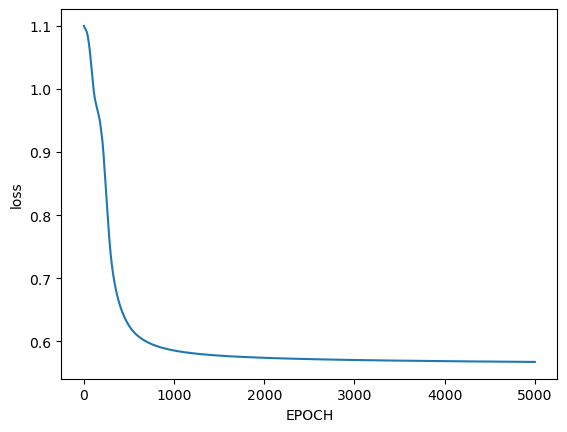

In [154]:
import matplotlib.pyplot as plt

plt.plot(range(1,EPOCH+1),loss_list)
plt.xlabel('EPOCH')
plt.ylabel('loss')
plt.show()